# 변수중요도 : Feature Importance



## 1.환경준비

### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

### 2) 데이터 로딩

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/boston.csv')
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


* 변수 설명
    * crim : 범죄율
    * zn : 대저택 비율
    * indus : 산업단지 비율
    * chas : 찰스 강변 여부
    * nox : 일산화질소 농도(공기오염도)
    * rm : 평균 주택당 방 수
    * age : 30년 이상된 주택 비율
    * dis : 주요 업무 지역 접근성 지수
    * rad : 고속도로 접근성 지수
    * tax  1만 달러당 재산세
    * ptratio : 교사 1명당 학생수
    * lstat : 하위계층 비율
    * black : 흑인비율(원래 숫자를 변형한 것임)
    * mdev : 타운별 집값 중위수(단위 : 1000달러)

### 3) 필요한 함수 생성

In [3]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

## 2.데이터 준비


### 1) x, y로 나누기 

In [4]:
target = 'medv'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2) 가변수화

### 3) train : validation 분할

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 2022)
x_train.shape

(404, 12)

## 3.Feature Importance

### 1) Decision Tree

In [7]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import * 

* 기본 모델

In [10]:
model = DecisionTreeRegressor()

model.fit(x_train, y_train)


DecisionTreeRegressor()

* 모델 시각화

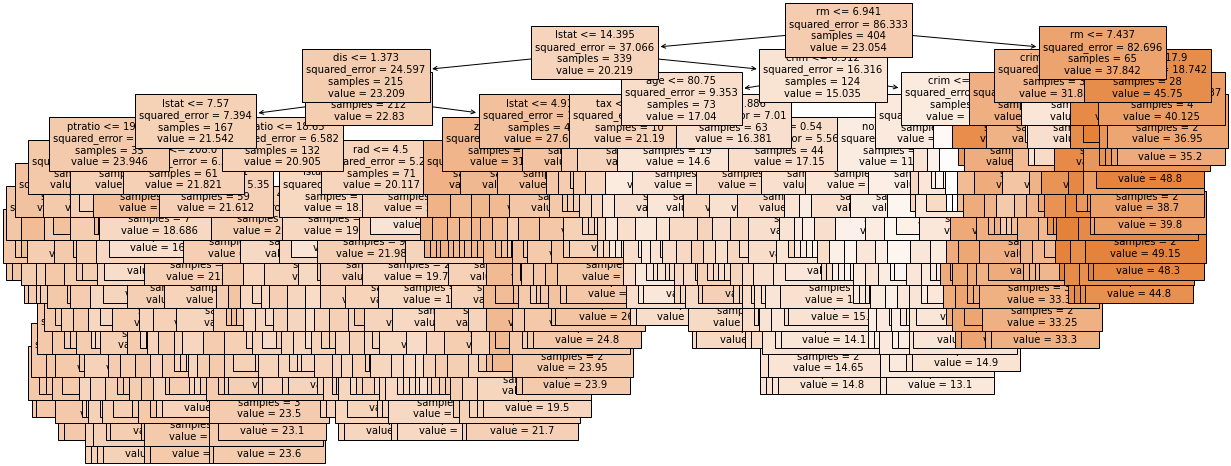

In [11]:
plt.figure(figsize = (20, 8))
plot_tree(model, feature_names = x.columns,
          filled = True, fontsize = 10);

* 변수 중요도

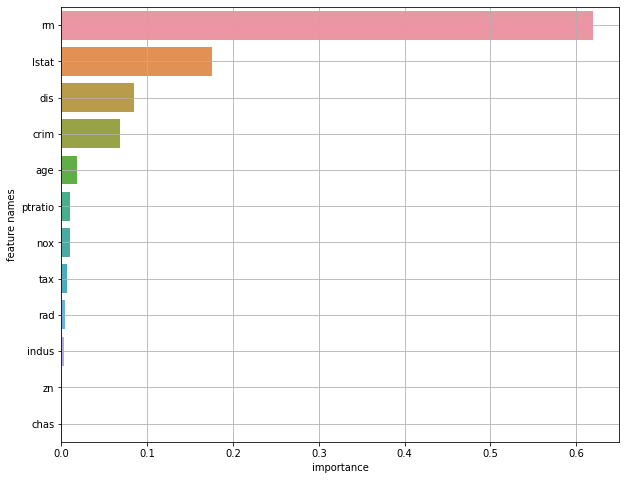

In [12]:
result = plot_feature_importance(model.feature_importances_, list(x))

In [13]:
result

,feature_names,feature_importance
0,rm,0.619286
1,lstat,0.176015
2,dis,0.084302
3,crim,0.068295
4,age,0.017787
5,ptratio,0.010173
6,nox,0.009579
7,tax,0.006476
8,rad,0.003789
9,indus,0.002794


* 성능 최적화 이후 변수 중요도 다시 확인

In [15]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth' : range(1, 50)}

model_gs = GridSearchCV(model,
                        params,
                        cv = 10,
                        verbose = 2)

model_gs.fit(x_train, y_train)


Fitting 10 folds for each of 49 candidates, totalling 490 fits
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END .....................................

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 50)}, verbose=2)

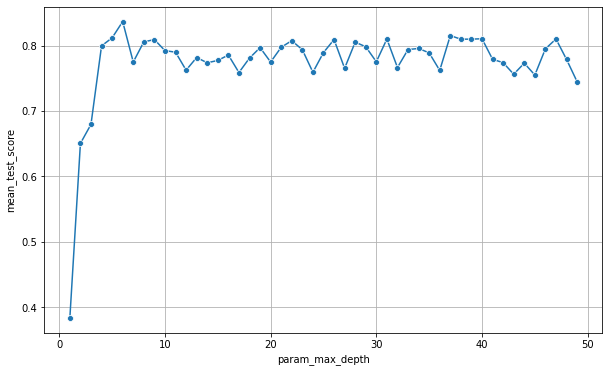

In [17]:
# 튜닝 과정 로그를 df로 저장
result = pd.DataFrame(model_gs.cv_results_)

plt.figure(figsize = (10,6))
sns.lineplot(x='param_max_depth', y='mean_test_score', data = result, marker = 'o')
plt.grid()
plt.show()

In [19]:
model_gs.best_params_

{'max_depth': 6}

In [24]:
fi = model_gs.best_estimator_.feature_importances_

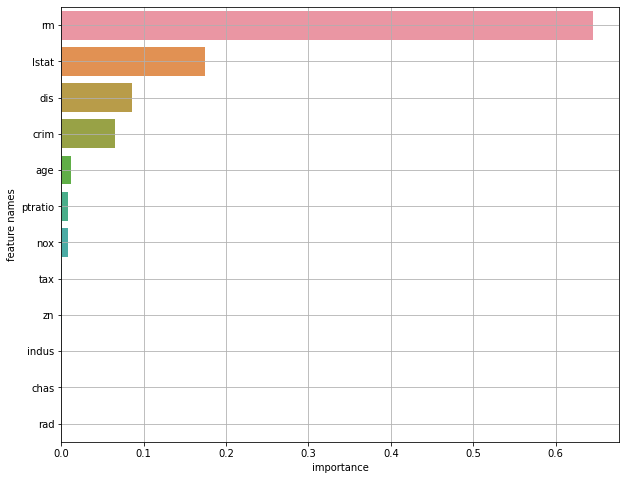

In [26]:
result = plot_feature_importance(fi, list(x))

### 2) Random Forest

* 기본모델링

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [44]:
n_est = 50
model = RandomForestRegressor(n_estimators = n_est)
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=50)

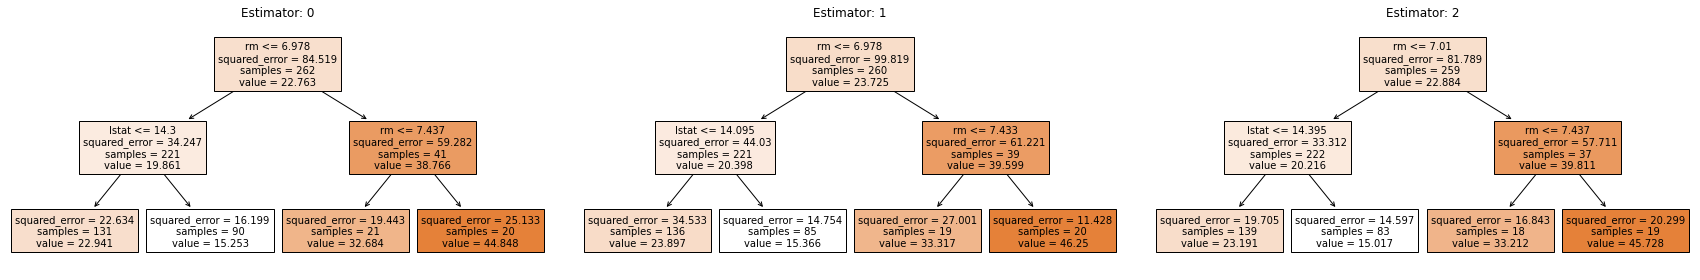

In [29]:
fn=list(x_train)
cn=["0","1"]
fig, axes = plt.subplots(nrows = 1,ncols = n_est,figsize = (24,4))
for index in range(0, n_est):
    plot_tree(model.estimators_[index],
                   feature_names = fn, 
                   class_names=cn,
                   filled = True, fontsize = 10,
                   ax = axes[index]);
    axes[index].set_title('Estimator: ' + str(index), fontsize = 12)
    
plt.tight_layout()
plt.show()

In [30]:
fi = x_train.iloc[0:0]
for i in range(n_est) :
    fi.loc[i] = model.estimators_[i].feature_importances_

In [32]:
fi

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,0.0,0.0,0.0,0.0,0.0,0.812646,0.0,0.0,0.0,0.0,0.0,0.187354
1,0.0,0.0,0.0,0.0,0.0,0.804859,0.0,0.0,0.0,0.0,0.0,0.195141
2,0.0,0.0,0.0,0.0,0.0,0.790693,0.0,0.0,0.0,0.0,0.0,0.209307


In [33]:
fi.mean(axis = 0)

crim       0.000000
zn         0.000000
indus      0.000000
chas       0.000000
nox        0.000000
rm         0.802733
age        0.000000
dis        0.000000
rad        0.000000
tax        0.000000
ptratio    0.000000
lstat      0.197267
dtype: float64

In [34]:
fi_rf = {}

for i, v in enumerate(list(x)) :
    fi_rf[v] = model.feature_importances_[i]

pd.DataFrame(fi_rf, index = [0])

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,0.0,0.0,0.0,0.0,0.0,0.802733,0.0,0.0,0.0,0.0,0.0,0.197267


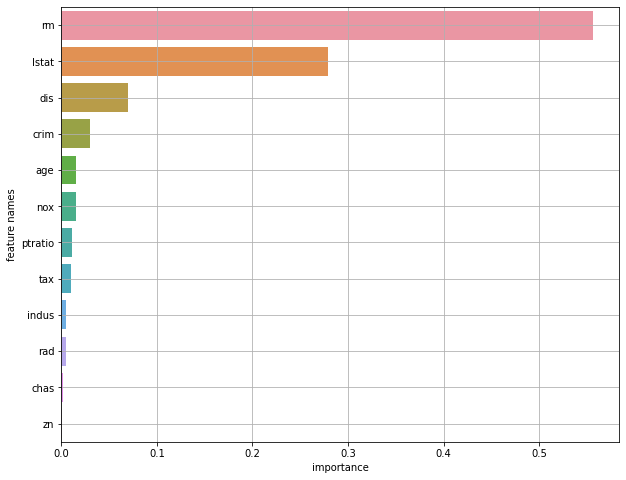

In [45]:
result = plot_feature_importance(model.feature_importances_, list(x))

* tree = 100개 Random Forest 모델 만들기

* 트리 전체 중요도 저장

In [ ]:
fi = x_train.iloc[0:0]
for i in range(100) :
    fi.loc[i] = model.estimators_[i].feature_importances_

In [ ]:
fi

* 트리 100개의 평균 중요도

In [ ]:
fi.mean(axis = 0)

In [ ]:
fi_rf = {}

for i, v in enumerate(list(x)) :
    fi_rf[v] = model.feature_importances_[i]

pd.DataFrame(fi_rf, index = [0])

### 3) XGB

In [36]:
from xgboost import XGBRegressor, plot_tree, plot_importance

* 기본 모델링

In [37]:
model = XGBRegressor(n_estimators = 10, max_depth = 2, objective='reg:squarederror')
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

* plot tree
    * plot tree함수는 XGB에서 제공합니다.
    * XGB에서의 트리 시각화는 여러 estimator중 하나씩만 가능합니다.

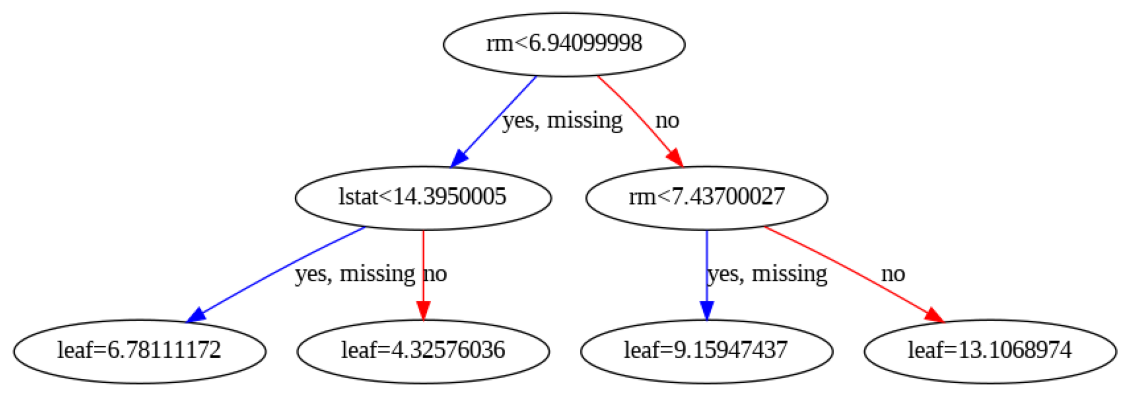

In [38]:
plt.rcParams['figure.figsize'] = 20,20
plot_tree(model)
plt.show()

* leaf 노드의 값 ==> 로지스틱 함수에 넣으면 0~1 사이의 값으로 변환됨.

* 몇가지 옵션
    * num_trees = 0
    * rankdir='LR'

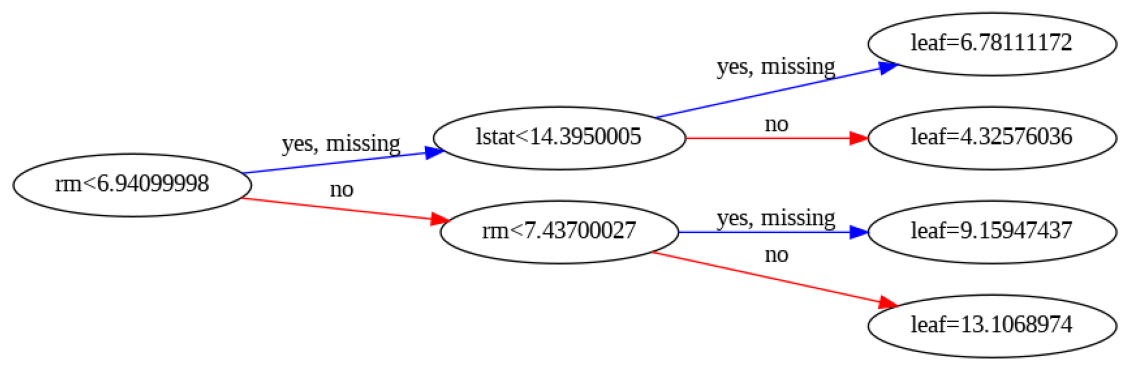

In [39]:
plot_tree(model, num_trees = 0, rankdir = 'LR')
plt.show()

* plot_importance
    * 변수중요도 기본값은 weight

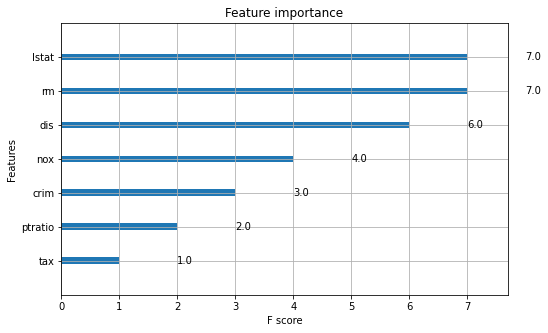

In [40]:
plt.rcParams['figure.figsize'] = 8, 5
plot_importance(model) # 디폴트가 weight
plt.show()

* model.feature_importances_ : 변수중요도 기본값은 gain.

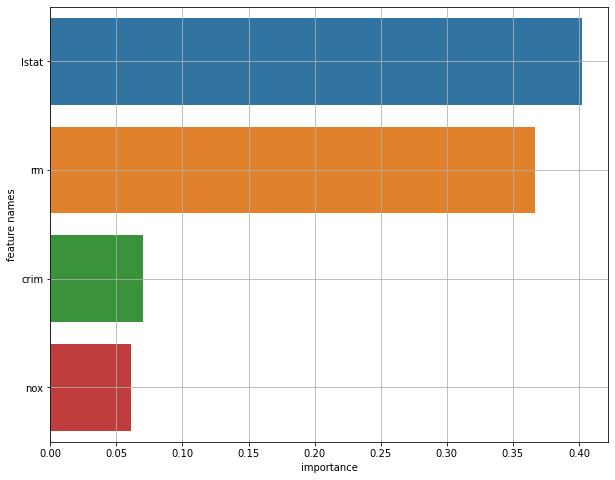

In [41]:
result = plot_feature_importance(model.feature_importances_, list(x),4)

* xgb의 변수 중요도
    * weight : 모델 전체에서 해당 feature가 split될 때 사용된 횟수의 합(plot_tree 에서의 기본값)
    * gain : feature별 평균 imformation gain.(model.feature_importances_ 의 기본값)
    * cover : feature가 split 할때의 샘플 수의 평균.

In [ ]:
# importance_type='weight'
plot_importance(model)
plt.show()

In [ ]:
# importance_type='gain'
plot_importance(model, importance_type='gain')
plt.show()

In [ ]:
# importance_type='cover'
plot_importance(model, importance_type='cover')
plt.show()

## 4.실습 : 직원 이직 예측모델 변수 중요도 비교

### 4.1 데이터 준비

* 데이터 로딩

In [46]:
# data data
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/Attrition2.csv"
data = pd.read_csv(path)
data.head(10)

,Attrition,Age,Department,DistanceFromHome,Education,EducationField,Gender,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,0,28,Research & Development,1,3,Medical,Female,Research Scientist,1,Married,3591,1,3,3,3,3,3
1,1,37,Research & Development,2,2,Other,Male,Laboratory Technician,3,Single,2090,6,2,7,3,3,0
2,0,27,Research & Development,8,5,Life Sciences,Male,Laboratory Technician,3,Married,4621,1,4,3,4,3,3
3,0,18,Research & Development,1,3,Life Sciences,Female,Laboratory Technician,4,Single,1611,1,3,0,5,4,0
4,0,29,Research & Development,9,3,Life Sciences,Male,Research Scientist,3,Married,2451,6,1,5,2,2,1
5,0,44,Research & Development,2,1,Medical,Male,Manufacturing Director,3,Single,10209,5,2,16,2,2,2
6,0,41,Sales,10,2,Life Sciences,Male,Sales Executive,4,Single,6230,7,4,16,3,3,14
7,0,25,Sales,18,1,Life Sciences,Male,Sales Executive,3,Married,6232,2,2,6,3,2,3
8,0,50,Research & Development,2,3,Medical,Male,Research Director,3,Married,17639,5,4,30,3,3,4
9,0,47,Sales,4,2,Life Sciences,Female,Sales Executive,4,Single,4163,1,3,9,0,3,9


|	변수 명	|	내용	|	구분	|
|	----	|	----	|	----	|
|	**Attrition**	|	이직여부, Yes = 1 , No = 0	|	**Target**	|
|	Age	|	나이	|	숫자	|
|	BusinessTravel	|	출장 빈도(범주)	|		|
|	Department	|	현 부서	|		|
|	DistanceFromHome	|	집-직장 거리(마일)	|	숫자	|
|	Education	|	교육수준(범주)	|	1 Below College, 2 College, 3 Bachelor, 4 Master, 5 Doctor	|
|	EducationField	|	전공	|		|
|	EnvironmentSatisfaction	|	근무환경에 대한 만족도(범주)	|	1 Low, 2 Good, 3 Excellent, 4 Outstanding	|
|	Gender	|	성별	|		|
|	JobInvolvement	|	직무 적극성(참여도)	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	JobRole	|	직무	|		|
|	JobSatisfaction	|	직무 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	MaritalStatus	|	결혼상태	|		|
|	MonthlyIncome	|	월급	|	숫자	|
|	NumCompaniesWorked	|	현재까지 근무한 회사 수	|	숫자	|
|	PercentSalaryHike	|	전년대비 급여인상율(%)	|	숫자	|
|	RelationshipSatisfaction	|	동료와의 관계 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	StockOptionLevel	|	스톡옵션 수준 0~3	|	범주	|
|	TotalWorkingYears	|	총 근무 연수	|	숫자	|
|	TrainingTimesLastYear	|	전년 교육훈련 횟수	|	숫자	|
|	WorkLifeBalance	|	워라밸. 일-삶 균형도	|	1 Bad, 2 Good, 3 Better, 4 Best	|
|	YearsAtCompany	|	현직장 근무 연수	|	숫자	|
|	YearsInCurrentRole	|	현직무 연수	|	숫자	|
|	YearsWithCurrManager	|	현 팀장과 근무한 연수	|	숫자	|


In [47]:
target = 'Attrition'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [48]:
y.value_counts() / y.shape[0]

0    0.913043
1    0.086957
Name: Attrition, dtype: float64

* 가변수화 Dummy Variable

In [49]:
dummy_vars = ['Education','Department','EducationField','Gender','JobRole','JobSatisfaction','MaritalStatus',
              'RelationshipSatisfaction','WorkLifeBalance'] 
x = pd.get_dummies(x, columns = dummy_vars, drop_first=True) 

* 데이터 분할
    * 이미 test set은 분할되어 있다고 가정합니다.
    * 주어진 데이터를 train set : validation set 으로 분할

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
# train_val에서 train : val = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 2022)

In [52]:
print(x_train.shape, x_val.shape)

(920, 38) (230, 38)


* class balance를 맞추기 위한 resampling

In [53]:
from imblearn.over_sampling import SMOTE

In [55]:
print(np.bincount(y_train))
print(np.bincount(y_train) / y_train.shape[0])

[833  87]
[0.90543478 0.09456522]


In [54]:
smote = SMOTE()
x_train_s, y_train_s = smote.fit_resample(x_train, y_train)

print(np.bincount(y_train_s))
print(np.bincount(y_train_s) / y_train_s.shape[0])

[833 833]
[0.5 0.5]


### 4.2 모델링 with Resampling
> * Resampling(up) 샘플링 데이터를 이용
* DecisionTreeClassifier, RandomForestClassifier, XGBClassifier를 이용하여 모델 생성
* validate set으로 예측하고 평가(classification report)해 봅시다.
* 각각의 변수중요도 비교하기.



* 모델링
    * DecisionTreeClassifier, RandomForestClassifier, XGBClassifier를 이용하여 모델 생성

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

* decision tree

In [81]:
# depth의 범위 1~10까지 안에서 그리드서치로 튜닝해 봅시다.
params = {'max_depth' : range(1, 11)}

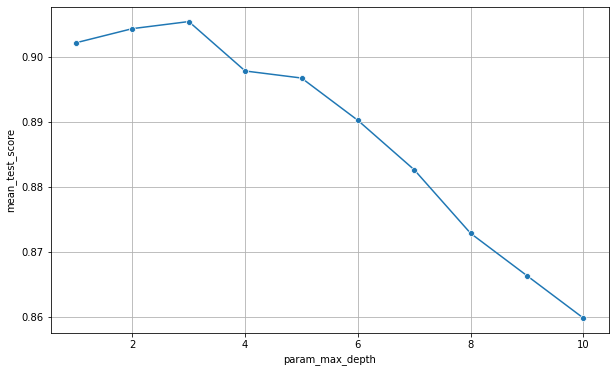

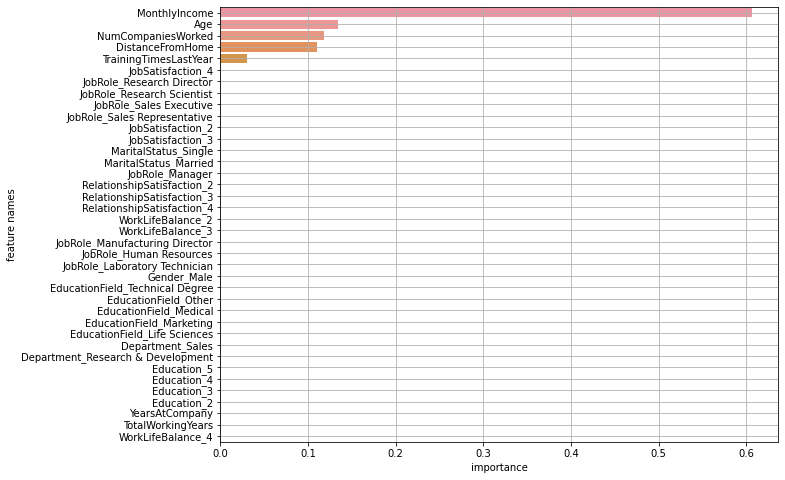

In [83]:
result = plot_feature_importance(model.best_estimator_.feature_importances_, list(x))

* rf

In [66]:
# 기본값으로 모델을 생성합니다.
model = RandomForestClassifier()

In [76]:
# 다음 범위로 그리드서치 튜닝을 진행합시다.
# max_depth : 1 ~ 6, learning_rate : 0.01 ~ 0.4, n_estimators : 50 ~ 150
params = {'max_depth' : range(1, 7), 'learning_rate' : np.linspace(0.01, 0.4, 50) ,'n_estimators' : [50, 150]}
model.fit(x_train, y_train)
model_rf = GridSearchCV(model,
                        params,
                        cv = 10,
                        verbose = 2)

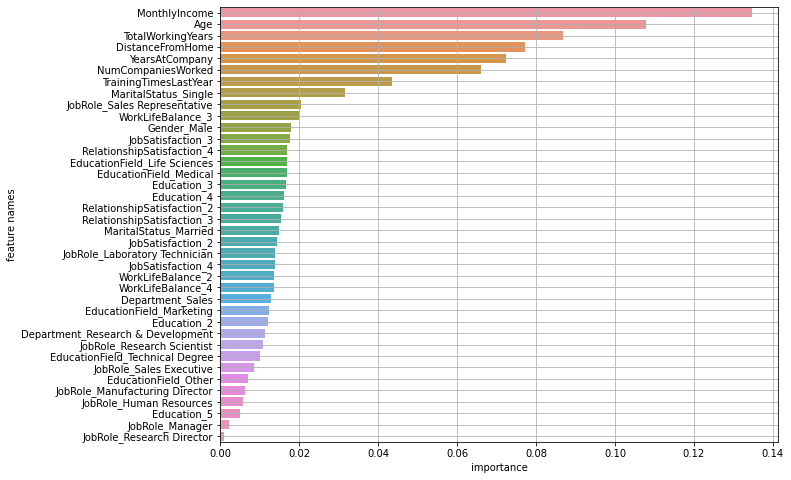

In [74]:
result = plot_feature_importance(model.feature_importances_, list(x))

xgb

In [78]:
model = XGBClassifier()


In [79]:
model = XGBClassifier(n_estimators = 10, max_depth = 2, objective='reg:squarederror')
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              objective='reg:squarederror', predictor=None, ...)

* 모델 성능 비교
    * 세 모델 중 성능이 가장 좋은 모델은?

* 변수 중요도 비교 : 세 모델간 변수 중요도를 비교해 봅시다. 

* 변수 중요도의 차이를 통해 무엇을 파악할 수 있나요?

______
